In [36]:
# load sample list
import os
import sys
sys.path.append("..")
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from openTSNE import TSNE
import torch

from train_router_mdeberta_v4 import RouterDataset, RouterModule
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import T5EncoderModel, T5Tokenizer, AutoTokenizer, DebertaV2Model

dataset_paths = ["../datasets/split2_model7_M_1/mmlu_train.json","../datasets/split2_model7_M_1/gsm8k-train.json", "../datasets/split2_model7_M_1/cmmlu_train.json", "../datasets/split2_model7_M_1/arc_challenge_train.json", "../datasets/split2_model7_M_1/humaneval_train.json",]

data_types = [ "multi_attempt", "probability", "probability", "probability", "multi_attempt"]

tokenizer = AutoTokenizer.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base", truncation_side='left', padding=True)
encoder_model = DebertaV2Model.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base").to("cuda")


number_per_dataset = 2000

router_datasets = [RouterDataset(data_path, data_type=data_types[i], dataset_id=i, size=number_per_dataset) for i, data_path in enumerate(dataset_paths)]
for router_dataset in router_datasets:
    router_dataset.register_tokenizer(tokenizer)
router_dataset = ConcatDataset(router_datasets)
router_dataloader = DataLoader(router_dataset, batch_size=64)


router_model = RouterModule(encoder_model, hidden_state_dim=768, node_size=len(router_datasets[0].router_node), similarity_function="cos").to("cpu")
router_model.to('cuda')


# get predicted label 
all_hidden_states = []
dataset_set_ids = []
cluster_ids = []
predicts = []
with torch.no_grad():
    for i, batch in enumerate(router_dataloader):
        input, _, dataset_id, cluster_id = batch
        input.to("cuda")
        predict, hidden_states = router_model(**input)
        dataset_set_ids.append(dataset_id)
        cluster_ids.append(cluster_id)
        predicts.append(predict)
        all_hidden_states.append(hidden_states)


all_hidden_states = torch.concat(all_hidden_states)
predicts = torch.concat(predicts)
cluster_ids = torch.concat(cluster_ids).numpy() 
_, max_index = torch.max(predicts, dim=1)
dataset_set_ids = torch.concat(dataset_set_ids).numpy()

/data/home/chensh/miniconda3/envs/vllm/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [43]:
from MulticoreTSNE import MulticoreTSNE as M_TSNE
from openTSNE import TSNE
np_hidden_states = all_hidden_states.cpu().numpy()
tsne_result = M_TSNE(n_components=5, n_jobs=12).fit_transform(np_hidden_states)

In [44]:
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
import random as random
import json

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import Normalize

n_clusters_list = [8]

seed = 42
random.seed(seed)
np.random.seed(seed)

for n_clusters in n_clusters_list:
    x = tsne_result
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000)

    # 对样本数据进行聚类
    kmeans.fit(x)

    # 获取聚类结果
    kmeans_labels = kmeans.labels_.tolist()
    # kmeans_labels = np.array(kmeans_labels)

    labels_split = [kmeans_labels[i*number_per_dataset: (i+1)*number_per_dataset] for i in range(len(dataset_paths))]
    base_output_path = f"/data/home/chensh/projects/LLM_router/datasets/split2_model7_M_1_cluster"
    os.makedirs(base_output_path, exist_ok=True)


    for i, data_path in enumerate(dataset_paths) :
        cluster_ids = labels_split[i]
        
        with open(data_path, 'r') as f:
            if data_path.endswith('.json'):
                sample_list = json.load(f)
        new_sample_list = []
        for j, sample in enumerate(sample_list):
            if j >= 2000:
                break
            new_sample = sample 
            new_sample['cluster_id'] = cluster_ids[j]
            new_sample_list.append(new_sample)
        with open(os.path.join(base_output_path, data_path.split('/')[-1]), "w" ) as f:
            json.dump(new_sample_list ,f)

In [26]:

tsne_result = M_TSNE(n_components=2, n_jobs=12).fit_transform(np_hidden_states)

tsne_result_x = [item[0] for item in tsne_result]
tsne_result_y = [item[1] for item in tsne_result]


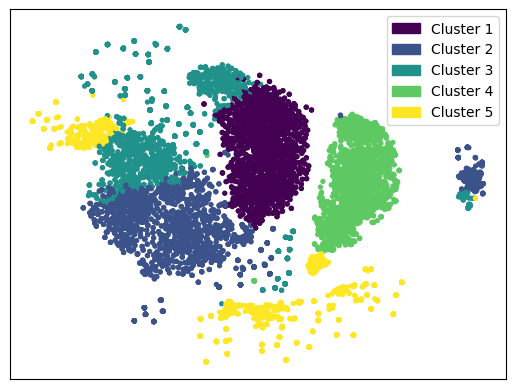

: 

In [45]:


# 假设 tsne_result_x 和 tsne_result_y 是你的数据点的坐标数组
# 假设 np_ids 是每个点的类别标签，每个类别的标签是唯一的整数

scatter = plt.scatter(tsne_result_x, tsne_result_y, c=kmeans_labels, cmap='viridis', s=8)

# 创建 colorbar
# cbar = plt.colorbar(scatter)

# 获取颜色映射和归一化实例
cmap = plt.cm.viridis
norm = Normalize(vmin=0, vmax=4)

# 创建图例的patches
labels=['MMLU','GSM8K','CMMLU','ARC-C','HumanEval']
legend_patches = [Patch(color=cmap(norm(i)), label=f'Cluster {i+1}') for  i, value in enumerate(labels)]

# 添加图例
plt.legend(handles=legend_patches)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)


In [14]:
import pandas as pd
import os
import json


output_file_path = "/data/home/chensh/projects/LLM_router/datasets/split2_model7_M_1"

with open(os.path.join(output_file_path, 'gsm8k-train.json'),'r') as f: 
    output_data = json.load(f)

print(output_data[0]['scores'])

{'mistralai/Mistral-7B-v0.1': 1.0, 'meta-math/MetaMath-Mistral-7B': 1.0, 'itpossible/Chinese-Mistral-7B-v0.1': 1.0, 'HuggingFaceH4/zephyr-7b-beta': 0.0, 'cognitivecomputations/dolphin-2.6-mistral-7b': 1.0, 'meta-llama/Meta-Llama-3-8B': 1.0, 'cognitivecomputations/dolphin-2.9-llama3-8b': 1.0}


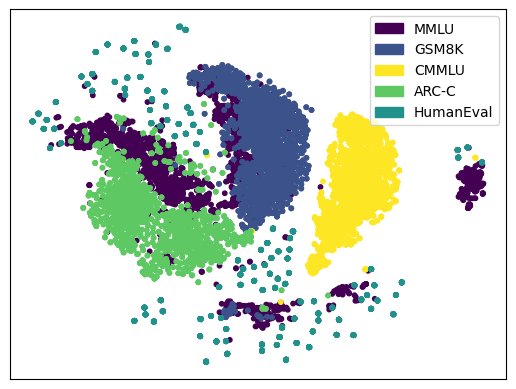

In [42]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.colors import Normalize

# 假设 tsne_result_x 和 tsne_result_y 是你的数据点的坐标数组
# 假设 np_ids 是每个点的类别标签，每个类别的标签是唯一的整数

index_4 = dataset_set_ids == 4
index_2 = dataset_set_ids == 2
dataset_set_ids[index_4] = 2
dataset_set_ids[index_2] = 4

# scatter = plt.scatter(tsne_result_x[:-2000], tsne_result_y[:-2000], c=np_ids[:-2000], cmap='viridis', s=8)
# plt.scatter(tsne_result_x[-2000:], tsne_result_y[-2000:], color = '#F04E4E', s=8)
scatter = plt.scatter(tsne_result_x, tsne_result_y, c=dataset_set_ids, cmap='viridis', s=10)

# 创建 colorbar
# cbar = plt.colorbar(scatter)

# 获取颜色映射和归一化实例
cmap = plt.cm.viridis
norm = Normalize(vmin=0, vmax=4)

# 创建图例的patches
labels=['MMLU','GSM8K','CMMLU','ARC-C','HumanEval']
legend_patches = [Patch(color=cmap(norm(0)), label='MMLU'),
                  Patch(color=cmap(norm(1)), label='GSM8K'),
                  Patch(color=cmap(norm(4)), label='CMMLU'),
                  Patch(color=cmap(norm(3)), label='ARC-C'),
                  Patch(color=cmap(norm(2)), label='HumanEval'),
                  ]
# legend_patches = [Patch(color=cmap(norm(i)), label=f'{value}') for  i, value in enumerate(labels)]
# legend_patches.append(Patch(color= '#F04E4E', label=f'{labels[-1]}'))

# 添加图例
plt.legend(handles=legend_patches)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)


TypeError: expected Tensor as element 0 in argument 0, but got int

[4,
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0

In [9]:
# generate cluster id using ref

# load sample list
import os
import sys
sys.path.append("..")
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from openTSNE import TSNE
import torch
import json

from train_router_mdeberta_v4 import RouterDataset, RouterModule
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import T5EncoderModel, T5Tokenizer, AutoTokenizer, DebertaV2Model

ref_dataset_paths = ["../datasets/split2_model7_cluster/mmlu_train.json","../datasets/split2_model7_cluster/gsm8k-train.json", "../datasets/split2_model7_cluster/cmmlu_train.json", "../datasets/split2_model7_cluster/arc_challenge_train.json", "../datasets/split2_model7_cluster/humaneval_train.json",]

data_types = [ "multi_attempt", "probability", "probability", "probability", "multi_attempt"]

number_per_dataset = 2000

tokenizer = AutoTokenizer.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base", truncation_side='left', padding=True)


router_datasets = [RouterDataset(data_path, data_type=data_types[i], dataset_id=i, size=number_per_dataset) for i, data_path in enumerate(ref_dataset_paths)]
for router_dataset in router_datasets:
    router_dataset.register_tokenizer(tokenizer)
router_dataset = ConcatDataset(router_datasets)
router_dataloader = DataLoader(router_dataset, batch_size=64)

# router_model = RouterModule(encoder_model, hidden_state_dim=768, node_size=len(router_datasets[0].router_node), similarity_function="cos").to("cpu")
# router_model.to('cuda')


# get ref label
dataset_set_ids = []
cluster_ids = []
with torch.no_grad():
    for i, batch in enumerate(router_dataloader):
        _, _, dataset_id, cluster_id = batch
        dataset_set_ids.append(dataset_id)
        cluster_ids.append(cluster_id)

cluster_ids = torch.concat(cluster_ids).numpy() 
dataset_set_ids = torch.concat(dataset_set_ids).numpy()

dataset_paths = ["../datasets/split2_model7_M_1/mmlu_train.json","../datasets/split2_model7_M_1/gsm8k-train.json", "../datasets/split2_model7_M_1/cmmlu_train.json", "../datasets/split2_model7_M_1/arc_challenge_train.json", "../datasets/split2_model7_M_1/humaneval_train.json",]


labels_split = [cluster_ids[i*number_per_dataset: (i+1)*number_per_dataset] for i in range(len(dataset_paths))]
base_output_path = f"/data/home/chensh/projects/LLM_router/datasets/split2_model7_M_1_cluster2"
os.makedirs(base_output_path, exist_ok=True)


for i, data_path in enumerate(dataset_paths) :
    cluster_ids = labels_split[i]
    
    with open(data_path, 'r') as f:
        if data_path.endswith('.json'):
            sample_list = json.load(f)
    new_sample_list = []
    for j, sample in enumerate(sample_list):
        if j >= 2000:
            break
        new_sample = sample 
        new_sample['cluster_id'] = int(cluster_ids[j])
        new_sample_list.append(new_sample)
    with open(os.path.join(base_output_path, data_path.split('/')[-1]), "w" ) as f:
        json.dump(new_sample_list ,f)

/data/home/chensh/miniconda3/envs/vllm/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


# One Task

In [3]:
# generate cluster id using ref

# load sample list
import os
import sys
sys.path.append("..")
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from openTSNE import TSNE
import torch
import json

from train_router_mdeberta_v4 import RouterDataset, RouterModule
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import T5EncoderModel, T5Tokenizer, AutoTokenizer, DebertaV2Model

dataset_paths = ["../datasets/split2_model7/humaneval_train.json",]

data_types = ["multi_attempt"]

number_per_dataset = 2000

tokenizer = AutoTokenizer.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base", truncation_side='left', padding=True)


router_datasets = [RouterDataset(data_path, data_type=data_types[i], dataset_id=i, size=number_per_dataset) for i, data_path in enumerate(dataset_paths)]
for router_dataset in router_datasets:
    router_dataset.register_tokenizer(tokenizer)
router_dataset = ConcatDataset(router_datasets)
router_dataloader = DataLoader(router_dataset, batch_size=64)




router_model = RouterModule(encoder_model, hidden_state_dim=768, node_size=len(router_datasets[0].router_node), similarity_function="cos").to("cpu")
router_model.to('cuda')


# get predicted label 
all_hidden_states = []
dataset_set_ids = []
cluster_ids = []
predicts = []
with torch.no_grad():
    for i, batch in enumerate(router_dataloader):
        input, _, dataset_id, cluster_id = batch
        input.to("cuda")
        predict, hidden_states = router_model(**input)
        dataset_set_ids.append(dataset_id)
        cluster_ids.append(cluster_id)
        predicts.append(predict)
        all_hidden_states.append(hidden_states)


all_hidden_states = torch.concat(all_hidden_states)
predicts = torch.concat(predicts)
cluster_ids = torch.concat(cluster_ids).numpy() 
_, max_index = torch.max(predicts, dim=1)
dataset_set_ids = torch.concat(dataset_set_ids).numpy()

/data/home/chensh/miniconda3/envs/vllm/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [4]:
from MulticoreTSNE import MulticoreTSNE as M_TSNE
from openTSNE import TSNE
np_hidden_states = all_hidden_states.cpu().numpy()
tsne_result = M_TSNE(n_components=5, n_jobs=12).fit_transform(np_hidden_states)

In [5]:
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
import random as random
import json

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import Normalize

n_clusters_list = [5]

seed = 42
random.seed(seed)
np.random.seed(seed)

for n_clusters in n_clusters_list:
    x = tsne_result
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000)

    # 对样本数据进行聚类
    kmeans.fit(x)

    # 获取聚类结果
    kmeans_labels = kmeans.labels_.tolist()
    # kmeans_labels = np.array(kmeans_labels)

    labels_split = [kmeans_labels[i*number_per_dataset: (i+1)*number_per_dataset] for i in range(len(dataset_paths))]
    base_output_path = f"/data/home/chensh/projects/LLM_router/datasets/one_task"
    os.makedirs(base_output_path, exist_ok=True)


    for i, data_path in enumerate(dataset_paths) :
        cluster_ids = labels_split[i]
        
        with open(data_path, 'r') as f:
            if data_path.endswith('.json'):
                sample_list = json.load(f)
        new_sample_list = []
        for j, sample in enumerate(sample_list):
            if j >= 2000:
                break
            new_sample = sample 
            new_sample['cluster_id'] = cluster_ids[j]
            new_sample_list.append(new_sample)
        with open(os.path.join(base_output_path, data_path.split('/')[-1]), "w" ) as f:
            json.dump(new_sample_list ,f)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
import pandas as pd 

humaneval_json = pd.read_json("/data/home/chensh/projects/LLM_router/datasets/one_task/humaneval_train.json")
humaneval_json["cluster_id"].value_counts() / len(humaneval_json["cluster_id"])

cluster_id
1    0.356522
3    0.208696
2    0.165217
0    0.156522
4    0.113043
Name: count, dtype: float64

: 

In [1]:
# load sample list
import os
import sys
sys.path.append("..")
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from openTSNE import TSNE
import torch

from train_router_mdeberta_routerbench import RouterDataset, RouterModule
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import T5EncoderModel, T5Tokenizer, AutoTokenizer, DebertaV2Model

# dataset_paths = ["../datasets/routerbench_zs/" + data + ".csv" for data in ["gsm8k_train", "hellaswag_train", "mbpp_train", "mmlu_train", "winograde_train", "arc_challenge_train"] ]

# dataset_paths = ["../datasets/routerbench_zs/" + data + ".csv" for data in ["mbpp_train"] ]

dataset_paths = ["../datasets/routerbench_zs/" + data + ".csv" for data in ["gsm8k_train"] ]

tokenizer = AutoTokenizer.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base", truncation_side='left', padding=True)
encoder_model = DebertaV2Model.from_pretrained("/data/home/chensh/data/huggingface_model/microsoft/mdeberta-v3-base").to("cuda")


number_per_dataset = 2000

router_datasets = [RouterDataset(data_path, dataset_id=i, size=number_per_dataset) for i, data_path in enumerate(dataset_paths)]
for router_dataset in router_datasets:
    router_dataset.register_tokenizer(tokenizer)
router_dataset = ConcatDataset(router_datasets)
router_dataloader = DataLoader(router_dataset, batch_size=64)


router_model = RouterModule(encoder_model, hidden_state_dim=768, node_size=len(router_datasets[0].router_node), similarity_function="cos").to("cpu")
router_model.to('cuda')


# get predicted label 
all_hidden_states = []
dataset_set_ids = []
cluster_ids = []
predicts = []
with torch.no_grad():
    for i, batch in enumerate(router_dataloader):
        input, _, dataset_id, cluster_id, costs = batch
        input.to("cuda")
        predict, hidden_states = router_model(**input)
        dataset_set_ids.append(dataset_id)
        cluster_ids.append(cluster_id)
        predicts.append(predict)
        all_hidden_states.append(hidden_states)



/data/home/chensh/miniconda3/envs/vllm/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/data/home/chensh/miniconda3/envs/vllm/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


NameError: name 'tsne_result' is not defined

32

In [2]:
all_hidden_states = torch.concat(all_hidden_states)
predicts = torch.concat(predicts)
cluster_ids = torch.concat(cluster_ids).numpy() 
_, max_index = torch.max(predicts, dim=1)
dataset_set_ids = torch.concat(dataset_set_ids).numpy()

from MulticoreTSNE import MulticoreTSNE as M_TSNE
from openTSNE import TSNE
np_hidden_states = all_hidden_states.cpu().numpy()
tsne_result = M_TSNE(n_components=5, n_jobs=12).fit_transform(np_hidden_states)




In [3]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
import random as random
import json

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import Normalize

n_clusters_list = [5]

seed = 42
random.seed(seed)
np.random.seed(seed)

for n_clusters in n_clusters_list:
    x = tsne_result
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000)

    # 对样本数据进行聚类
    kmeans.fit(x)

    # 获取聚类结果
    kmeans_labels = kmeans.labels_.tolist()
    # kmeans_labels = np.array(kmeans_labels)

    labels_split = [kmeans_labels[i*number_per_dataset: (i+1)*number_per_dataset] for i in range(len(dataset_paths))]
    base_output_path = f"/data/home/chensh/projects/LLM_router/datasets/routerbench_one_task"
    os.makedirs(base_output_path, exist_ok=True)

    for i, data_path in enumerate(dataset_paths) :
        cluster_ids = labels_split[i]
        sample_df = pd.read_csv(data_path)
        new_sample_df = sample_df[:min(len(sample_df), number_per_dataset)]
        new_sample_df["cluster_id"] = cluster_ids[:min(len(sample_df), number_per_dataset)]
        new_sample_df.to_csv(os.path.join(base_output_path, data_path.split('/')[-1]), index=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_2944963/3858213790.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_sample_df["cluste

In [12]:

from collections import Counter

# 示例列表
for i in range(5):
    num_list = labels_split[i][:2000]

    # 使用Counter统计数值的分布
    num_distribution = Counter(num_list)

    # 输出每个数值及其出现的次数
    for num, count in num_distribution.items():
        print(f"Number {num} appears {count} times.")

Number 2 appears 1997 times.
Number 1 appears 3 times.
Number 4 appears 2000 times.
Number 6 appears 893 times.
Number 0 appears 645 times.
Number 5 appears 462 times.
Number 3 appears 994 times.
Number 1 appears 361 times.
Number 5 appears 333 times.
Number 7 appears 171 times.
Number 4 appears 141 times.
Number 7 appears 1356 times.
Number 3 appears 644 times.


In [15]:
dataset_paths

['../datasets/routerbench_zs/gsm8k_train.csv',
 '../datasets/routerbench_zs/hellaswag_train.csv',
 '../datasets/routerbench_zs/mbpp_train.csv',
 '../datasets/routerbench_zs/mmlu_train.csv',
 '../datasets/routerbench_zs/winograde_train.csv',
 '../datasets/routerbench_zs/arc_challenge_train.csv']